# Batch Stream active learning cycle
In this notebook, we will show how pool-based active learning strategies can be used in a stream environment. We showcase the methods available in the pool package. 

In [1]:
# extending the path is only needed for using the skactiveml package within the 
# github repository instead of the installed version (e.g., from pypi).
import sys
sys.path.append('../..')

import numpy as np
from scipy.ndimage import gaussian_filter1d
import sklearn
import sklearn.datasets
import matplotlib.pyplot as plt
import copy
from sklearn import clone
from collections import deque
from skactiveml.classifier import PWC, SklearnClassifier
from skactiveml.pool import RandomSampler, UncertaintySampling, McPAL, ALCE, EpistemicUncertainty, ExpectedErrorReduction, FourDS
from skactiveml.utils import call_func, MISSING_LABEL
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

## Initialize batch stream Parameters
Before the experiments can start, we need to construct a random data set. For this, we specify the necessary parameters in the cell below. To make the experiment repeatable, we will use the random_state object to generate all other random seeds, such that we only need to explicitly specify a single random seed. Furthermore, we specify the length of the data stream (stream_length) and the size of the sliding window that defines the available training data (training_size). To create the stream environment we define a budget (batch_size) for the defined batch size (stream_batch_size).

In [2]:
# random state that is used to generate random seeds
random_state = np.random.RandomState(0)
# number of instances that are provided to the classifier
init_train_length = 10
# the length of the data stream
stream_length = 10000
# the size of the sliding window that limits the training data
training_size = 1000
# define a stream batch size
stream_batch_size = 10
# define a batch size which in the stream enviremont would be a budget
batch_size = 2
# number of classes
n_classes = 2

## Random seed generation
The get_randomseed function simplifies the generation of a new random seed from a given random state object. For this notebook, this random state object will be always the random_state obejct defined above.

In [3]:
def get_randomseed(random_state):
    return random_state.randint(2**31-1)

## Generate and initialize data set
The next block initializes the tested data set. We use scikit-learn to generate a random dataset with our pre-defined stream length. The data set consists of multiple parts. X represents the location of the instance within the feature space. The class for each instance is denoted by y. 
For models that need at least some initial training data, we generate samples to train an initial model. These are denoted by the suffix "_init", while all data used within the active learning cycle are denoted by the suffix "_stream".

In [4]:
X, y = sklearn.datasets.make_classification(n_samples=init_train_length + stream_length, n_classes=n_classes, random_state=get_randomseed(random_state), shuffle=True)
X_init = X[:init_train_length, :]
y_init = y[:init_train_length]
X_stream = X[init_train_length:, :]
y_stream = y[init_train_length:]

## Initialize query strategies
Next, we initialize the classifier and the base query strategies that we want to compare. To guarantee that the classifier is not affected by previous repetitions, we use factory functions to separate the classifier for each experiment run.

In [5]:
# McPAL only works with PWC therefore the other classifier are not used in this example
clf_dict = {# 'GaussianNaiveBayes' : lambda: SklearnClassifier(GaussianNB(), missing_label=MISSING_LABEL),
            # 'DecisionTree' : lambda: SklearnClassifier(DecisionTreeClassifier(), missing_label=MISSING_LABEL),
            # 'LinearSVC' : lambda: SklearnClassifier(SVC(probability=True), missing_label=MISSING_LABEL),
            # 'PWCWrapped' : lambda: SklearnClassifier(PWC(classes=[0,1]), missing_label=MISSING_LABEL),
            'PWC' : lambda: PWC(classes=[0,1], random_state=get_randomseed(random_state))}
query_strategies = {
    'RandomSampler': RandomSampler(random_state=get_randomseed(random_state)),
    'UncertaintySampling': UncertaintySampling(random_state=get_randomseed(random_state)),
    'McPAL': McPAL(random_state=get_randomseed(random_state)),
    # 'FourDS': FourDS(random_state=get_randomseed(random_state)),
    'ExpectedErrorReduction': ExpectedErrorReduction(random_state=get_randomseed(random_state)),
    'EpistemicUncertainty': EpistemicUncertainty(random_state=get_randomseed(random_state)),
    'ALCE': ALCE(classes=[c for c in range(n_classes)], random_state=get_randomseed(random_state)),
}

## Start the active learning cycle
After all, variables are initialized, we can start the experiment. The experiment loop below goes through all query strategies defined in query_strategies. For each experiment run, the average accuracy of the selected query strategies will be displayed. Lastly, the accuracy over time will be plotted.

Query Strategy:  RandomSampler , Avg Accuracy:  0.7714 , Acquisation count: 2000
Query Strategy:  UncertaintySampling , Avg Accuracy:  0.8413 , Acquisation count: 2000
Query Strategy:  McPAL , Avg Accuracy:  0.8433 , Acquisation count: 2000
Query Strategy:  ExpectedErrorReduction , Avg Accuracy:  0.517 , Acquisation count: 2000
Query Strategy:  EpistemicUncertainty , Avg Accuracy:  0.8427 , Acquisation count: 2000
Query Strategy:  ALCE , Avg Accuracy:  0.714 , Acquisation count: 2000


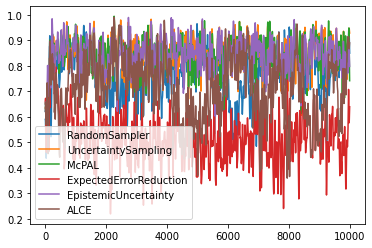

In [6]:
for query_strategy_name, query_strategy in query_strategies.items():
    for clf_name, clf_factory in clf_dict.items():
        clf = clf_factory()
        # initializing the training data
        X_train = deque(maxlen=training_size)
        X_train.extend(X_init)
        y_train = deque(maxlen=training_size)
        y_train.extend(y_init)
        # train the model with the initially available data
        clf.fit(X_train, y_train)
        # initialize the list that stores the result of the classifier's prediction
        correct_classifications = []
        count = 0
        for t in range(0, len(X_stream), stream_batch_size):
            # create batch samples
            X_cand = X_stream[t: t + stream_batch_size]
            y_cand_true = y_stream[t: t + stream_batch_size]
            correct_classifications.extend(clf.predict(X_cand) == y_cand_true)
            # check whether to sample the instance or not
            # call_func is used since a classifier is not needed for RandomSampler
            X_train_array = np.array(X_train).reshape([len(X_train), X_cand.shape[1]])
            sampled_indices = call_func(query_strategy.query, X_cand=X_cand, clf=clone(clf), X=X_train_array, y=np.array(y_train), batch_size=batch_size)
            count += len(sampled_indices)
            X_train.extend(X_cand)
            y_cand = np.full(shape=y_cand_true.shape, fill_value=MISSING_LABEL)
            y_cand[sampled_indices] = y_cand_true[sampled_indices]
            y_train.extend(y_cand)
            # train the classifier
            clf.fit(X_train, y_train)
        # calculate and show the average accuracy 
        print("Query Strategy: ", query_strategy_name, ", Avg Accuracy: ", np.mean(correct_classifications), ", Acquisation count:", count)
        # smoothing the accuracy for plotting
        plt.plot(gaussian_filter1d(np.array(correct_classifications, dtype=float), 20), label=query_strategy_name)
plt.legend()